<a href="https://colab.research.google.com/github/jsebastianquiroga/DEEP_LEARNING_PUJ/blob/main/RNN_Forecast/googl_msft_aapl_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img style="float: center; padding-right: 10px;" src="https://www.pikpng.com/pngl/b/467-4670553_universidad-javeriana-esslingen-am-neckar-clipart.png" width="100" height="150">



<h1> <strong>Aprendizaje Profundo.</strong></h1> 
<h2> Para: Ing. Julio Omar Palacio Niño, M.Sc.</br></h2>
<h2>Integrantes:</br></h2>
<h2>Antonio Jose Caicedo.</br></h2>
<h2>Juan Sebastián Quiroga Bernal. </h2>
<h2>Leonardo García.</br></h2>

**Este colab puede ser ejecutado por cualquier usuario sin necesidad de cargar los archivos al entorno, debido a que la conexión está configurada para acceder a los archivos desde la nube**.

<h1> <strong>Taller 2: Predicción del Precio Más Alto de Acciones con Modelos Recurrentes.</strong></h1> 

En este notebook exploraremos diferentes propuestas de modelos recurrentes para la predicción del precio más alto de las acciones de Google (GOOGL), Microsoft (MSFT) y Apple (AAPL). Para ello, utilizaremos un conjunto de datos de los precios históricos de estas acciones, que contiene datos diarios incluyendo el precio de apertura, cierre, máximo, mínimo y volumen de operaciones.

El conjunto de datos se encuentra dividido en un conjunto de entrenamiento y un conjunto de prueba. En este notebook, implementaremos diferentes arquitecturas de modelos recurrentes utilizando la biblioteca Keras, incluyendo RNNs, LSTM, GRU y Transformers, y evaluaremos su rendimiento en términos de error de predicción.

El objetivo de este proyecto es explorar diferentes técnicas y arquitecturas de modelos recurrentes para mejorar la precisión de la predicción del precio más alto de estas acciones.

Los datos históricos de las acciones pueden ser obtenidos de diferentes fuentes, una opción recomendable es Yahoo Finance: 
- GOOGL: https://finance.yahoo.com/quote/GOOGL/history
- MSFT: https://finance.yahoo.com/quote/MSFT/history
- AAPL: https://finance.yahoo.com/quote/AAPL/history

El presente notebook, estará dividido en las siguientes partes:
<ol>
<li> Carga y preparación del conjunto de datos. </li>
<li> Exploración del conjunto de datos y su comprensión. </li>
<li> Transformación y preparación de datos. </li>
<li> Implementación y entrenamiento del modelo RNN. </li>
<li> Implementación y entrenamiento del modelo LSTM. </li>
<li> Implementación y entrenamiento del modelo GRU. </li>
<li> Implementación y entrenamiento del modelo Transformer. </li>
<li> Análisis de resultados de los modelos. </li>
<li> Bonus: Mejora de los modelos. </li>
</ol>


 <a id="carque"></a>
# 1. Cargue del data set.


con base a poder predecir el valor de las acciones de los tres gigantes  de tecnologia, se conecta con la API de yahoo para traer los ultimo cinco años de información pero como se usara como asistente de inversion, se quiere modelar los valores de venta maximos.

In [21]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [22]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [23]:
import yfinance as yf

# Define the tickers for the stocks you're interested in
tickers = ['GOOGL', 'MSFT', 'AAPL']

# Define the period for which you want data
period = '5y'  # 5 years

# Fetch the data
data = yf.download(tickers, period=period)
data = data[['High']].reset_index()
data.columns = ['Date', 'AAPL', 'GOOGL', 'MSFT']
data

[*********************100%***********************]  3 of 3 completed


,Date,AAPL,GOOGL,MSFT
0,2018-05-29,47.187500,54.067001,98.879997
1,2018-05-30,47.000000,53.949501,99.250000
2,2018-05-31,47.057499,55.500000,99.989998
3,2018-06-01,47.564999,56.908001,100.860001
4,2018-06-04,48.355000,57.893002,101.860001
...,...,...,...,...
1253,2023-05-19,176.389999,125.970001,318.750000
1254,2023-05-22,174.710007,126.430000,322.589996
1255,2023-05-23,173.380005,124.629997,322.720001
1256,2023-05-24,172.419998,121.910004,316.500000


Se tienen un total de 1259 datos, el cual se utilizara los ultimos 90 dias para predeccir y el restante para el entrenamiento del modelo

# 2. Exploración del conjunto de datos y su comprensión.

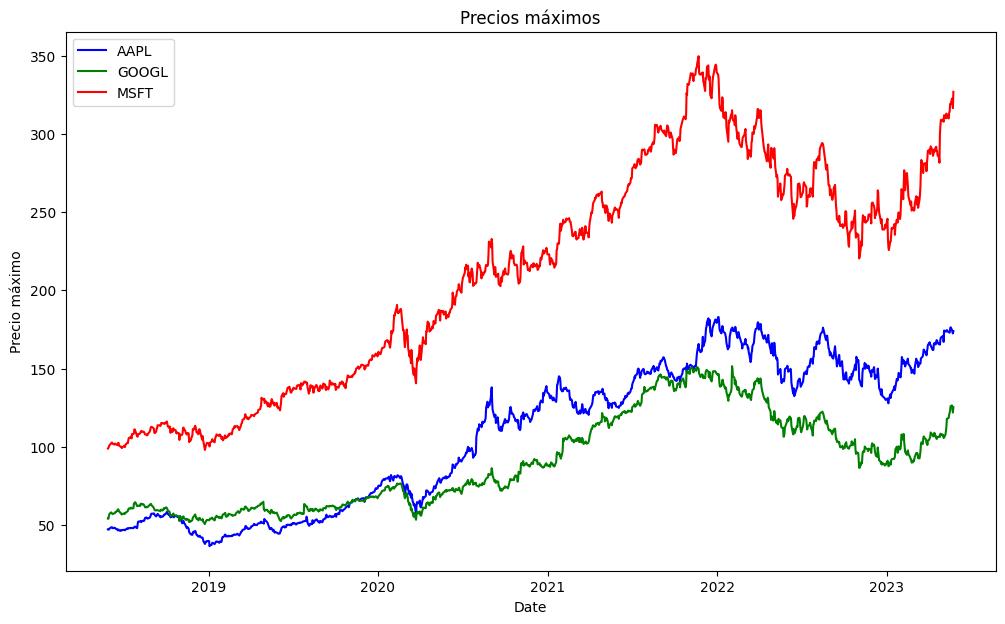

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Define colors for each stock
colors = ['blue', 'green', 'red']

# Plotting
plt.figure(figsize=(12, 7))

# Line plot for each stock with specified colors
line_AAPL = sns.lineplot(data=data, x="Date", y="AAPL", color=colors[0])
line_GOOGL = sns.lineplot(data=data, x="Date", y="GOOGL", color=colors[1])
line_MSFT = sns.lineplot(data=data, x="Date", y="MSFT", color=colors[2])

plt.ylabel("Precio máximo")
plt.title("Precios máximos")

# Create custom legend handles with specified colors
legend_elements = [
    Line2D([0], [0], color=colors[0], label='AAPL'),
    Line2D([0], [0], color=colors[1], label='GOOGL'),
    Line2D([0], [0], color=colors[2], label='MSFT')
]

# Add custom legend handles to the plot
plt.legend(handles=legend_elements)
plt.show()


visulamente se observa como tienen una relación similar en los ultomos años, el valor mas alto de negociacion de Microsoft siempre ha sido muy superior al de sus otros dos competidores

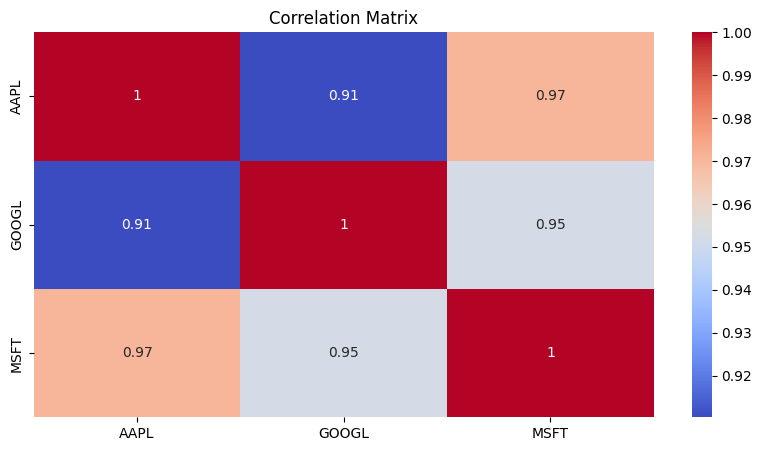

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(10,5))

# Correlation matrix
corr = data[['AAPL', 'GOOGL', 'MSFT']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Relacionado con el grafico de tendencia que se percibe, se identifica una alta correción entre estos activos, argumentando lo que visualmente se observa en el grafico de tendencia.

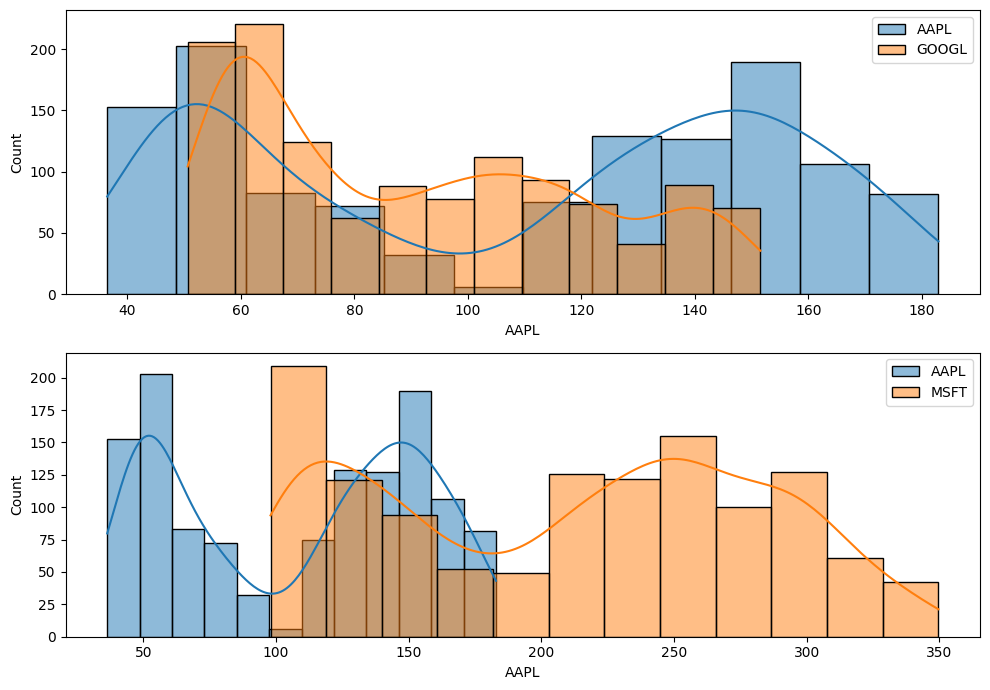

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(10,7))

stocks = ['GOOGL', 'MSFT']

for i, stock in enumerate(stocks):
    sns.histplot(data['AAPL'], kde=True, label='AAPL', ax=axes[i])
    sns.histplot(data[stock], kde=True, label=stock, ax=axes[i])
    axes[i].legend()

plt.tight_layout()
plt.show()

Se identifica que la distribución de los precios maximos difiere basntante que la de sus competidores, y el grafico KDE  se puede observar como la distirbuición de probabilidad de Appel es mas similar a google que la de microsoft 

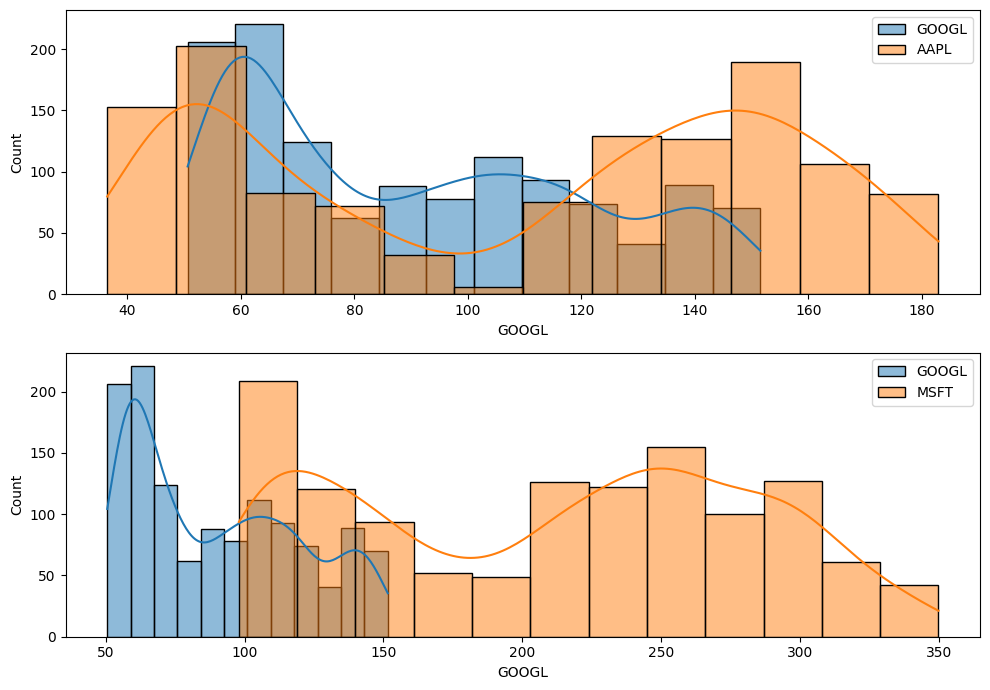

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(10,7))

stocks = ['AAPL', 'MSFT']

for i, stock in enumerate(stocks):
    sns.histplot(data['GOOGL'], kde=True, label='GOOGL', ax=axes[i])
    sns.histplot(data[stock], kde=True, label=stock, ax=axes[i])
    axes[i].legend()

plt.tight_layout()
plt.show()

La distribuicion de probabilidad y de Google mantiene la relacion con Apple pero al igual que este diverge mucho de microsoft

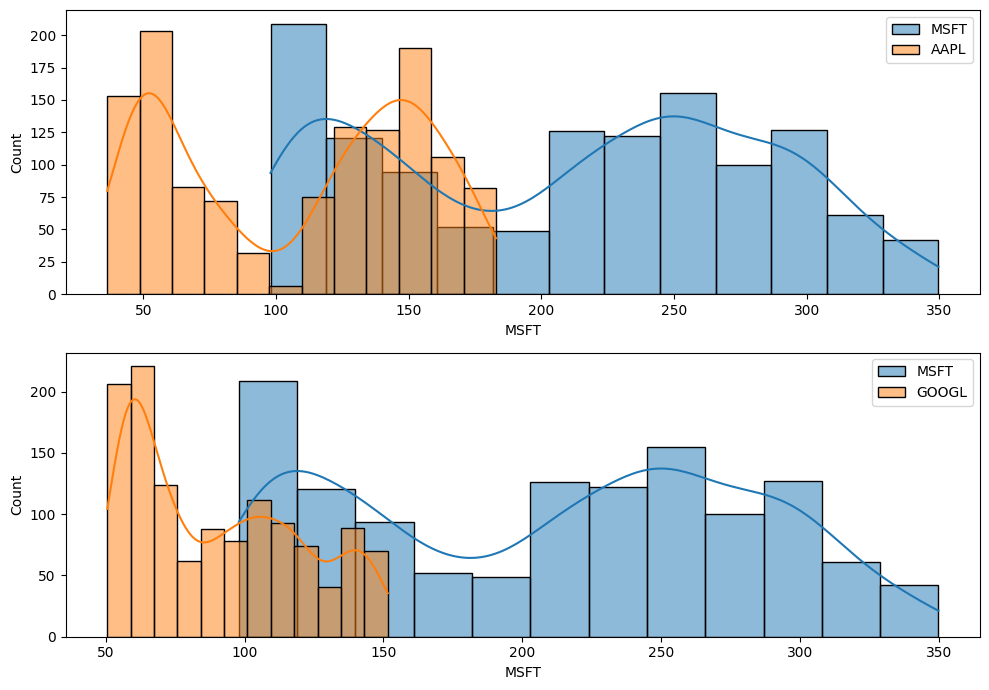

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(10,7))

stocks = ['AAPL', 'GOOGL']

for i, stock in enumerate(stocks):
    sns.histplot(data['MSFT'], kde=True, label='MSFT', ax=axes[i])
    sns.histplot(data[stock], kde=True, label=stock, ax=axes[i])
    axes[i].legend()

plt.tight_layout()
plt.show()

La distribuciones de microsoft son muy diferente a la de sus dos competidores antes mencionado.

In [29]:
from scipy.stats import ks_2samp

# Calculate KS statistic between AAPL and each other stock
for stock in ['GOOGL', 'MSFT']:
    stat, p = ks_2samp(data['AAPL'], data[stock])
    print(f'KS test between AAPL and {stock}:')
    print(f'Statistic: {stat}')
    print(f'p-value: {p}\n')

# Calculate KS statistic between AAPL and each other stock
for stock in ['AAPL', 'MSFT']:
    stat, p = ks_2samp(data['GOOGL'], data[stock])
    print(f'KS test between GOOGL and {stock}:')
    print(f'Statistic: {stat}')
    print(f'p-value: {p}\n')

# Calculate KS statistic between AAPL and each other stock
for stock in ['AAPL', 'GOOGL']:
    stat, p = ks_2samp(data['MSFT'], data[stock])
    print(f'KS test between MSFT and {stock}:')
    print(f'Statistic: {stat}')
    print(f'p-value: {p}\n')

KS test between AAPL and GOOGL:
Statistic: 0.3298887122416534
p-value: 5.51036345057333e-61

KS test between AAPL and MSFT:
Statistic: 0.6208267090620032
p-value: 4.448459255707732e-227

KS test between GOOGL and AAPL:
Statistic: 0.3298887122416534
p-value: 5.51036345057333e-61

KS test between GOOGL and MSFT:
Statistic: 0.6947535771065183
p-value: 7.6399313616597e-291

KS test between MSFT and AAPL:
Statistic: 0.6208267090620032
p-value: 4.448459255707732e-227

KS test between MSFT and GOOGL:
Statistic: 0.6947535771065183
p-value: 7.6399313616597e-291



Los resultados anteriores provienen de la prueba de Kolmogorov-Smirnov (KS), que es una prueba no paramétrica que compara las distribuciones de dos conjuntos de datos. En este caso, parece que estamos comparando la distribución de los precios de las acciones de Apple (AAPL), Google (GOOGL) y Microsoft (MSFT).

Los resultados del test KS muestran valores estadísticos notables y p-valores extremadamente bajos en todas las comparaciones. Un p-valor muy bajo (significativamente menor a 0.05) sugiere que podemos rechazar la hipótesis nula de que las dos distribuciones son idénticas. En otras palabras, sugiere que hay una diferencia significativa entre las distribuciones de precios de las acciones de estas compañías.

Observamos que la estadística KS es mayor cuando comparamos MSFT y GOOGL (0.6934), y MSFT y AAPL (0.6195), lo que sugiere que las distribuciones de los precios de las acciones de MSFT y de estas dos compañías son las que tienen mayores diferencias. En contraste, las distribuciones de los precios de las acciones de AAPL y GOOGL son las que menos difieren, con una estadística KS de 0.3296.

En resumen, estos resultados nos sugieren que las distribuciones de precios de las acciones de estas tres compañías son significativamente diferentes entre sí, con las mayores diferencias observadas entre MSFT y las otras dos compañías.

# 3. Transformación y preparación de datos:

Se normalizan los datos para que estén en un rango común. Puedes utilizar técnicas como la escala Min-Max.

In [30]:
data

,Date,AAPL,GOOGL,MSFT
0,2018-05-29,47.187500,54.067001,98.879997
1,2018-05-30,47.000000,53.949501,99.250000
2,2018-05-31,47.057499,55.500000,99.989998
3,2018-06-01,47.564999,56.908001,100.860001
4,2018-06-04,48.355000,57.893002,101.860001
...,...,...,...,...
1253,2023-05-19,176.389999,125.970001,318.750000
1254,2023-05-22,174.710007,126.430000,322.589996
1255,2023-05-23,173.380005,124.629997,322.720001
1256,2023-05-24,172.419998,121.910004,316.500000


In [31]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Define el número de días a predecir
prediction_days = 90

# Obtener las columnas numéricas para la normalización
numeric_columns = ['AAPL', 'GOOGL', 'MSFT']

# Realizar la normalización de los datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

# Define el tamaño de la secuencia
sequence_length = 10

# Define el número de bloques para la Validación cruzada en bloque
num_blocks = 5  # Por ejemplo, dividir en 5 bloques de tiempo

# Calcula el tamaño de cada bloque
block_size = len(scaled_data) // num_blocks

# Inicializa listas para almacenar los resultados de la validación cruzada
train_input_list = []
train_target_list = []
val_input_list = []
val_target_list = []
test_input_list = []
test_target_list = []

# Prepara los datos de entrenamiento y prueba en secuencias
def create_sequences(data, sequence_length, prediction_days):
    input_sequences = []
    target_sequences = []

    for i in range(len(data) - sequence_length - prediction_days + 1):
        input_sequences.append(data[i:i+sequence_length])
        target_sequences.append(data[i+sequence_length:i+sequence_length+prediction_days])

    return np.array(input_sequences), np.array(target_sequences)

# Realiza la Validación cruzada en bloque
for i in range(num_blocks):
    # Divide los datos en bloques de entrenamiento, validación y prueba
    start_index = i * block_size
    end_index = (i + 1) * block_size
    
    if i == num_blocks - 1:
        end_index = len(scaled_data)  # Asegura que el último bloque contenga el resto de los datos
    
    train_data = np.concatenate((scaled_data[:start_index], scaled_data[end_index:]), axis=0)
    test_data = scaled_data[start_index:end_index]
    
    # Divide el bloque de entrenamiento en entrenamiento y validación
    val_size = len(train_data) // num_blocks
    val_data = train_data[-val_size:]
    train_data = train_data[:-val_size]
    
    # Prepara los datos de entrenamiento, validación y prueba en secuencias
    train_input, train_target = create_sequences(train_data, sequence_length, prediction_days)
    val_input, val_target = create_sequences(val_data, sequence_length, prediction_days)
    test_input, test_target = create_sequences(test_data, sequence_length, prediction_days)

    
    # Almacena las secuencias y valores objetivo en listas
    train_input_list.append(train_input)
    train_target_list.append(train_target)
    val_input_list.append(val_input)
    val_target_list.append(val_target)
    test_input_list.append(test_input)
    test_target_list.append(test_target)

# Combina todas las secuencias y valores objetivo
train_input, train_target = create_sequences(train_data, sequence_length, prediction_days)
val_input, val_target = create_sequences(val_data, sequence_length, prediction_days)
test_input, test_target = create_sequences(test_data, sequence_length, prediction_days)

# Muestra de ejemplo de cómo utilizar los datos de prueba

print("Datos de entrenamiento:")
print(train_input.shape)  # Imprime la forma de los datos de prueba
print(train_target.shape)  # Imprime la forma de los valores objetivo de prueba

print("Datos de validación:")
print(val_input.shape)  # Imprime la forma de los datos de prueba
print(val_target.shape)  # Imprime la forma de los valores objetivo de prueba

print("Datos de prueba:")
print(test_input.shape)  # Imprime la forma de los datos de prueba
print(test_target.shape)  # Imprime la forma de los valores objetivo de prueba

Datos de entrenamiento:
(705, 10, 3)
(705, 90, 3)
Datos de validación:
(101, 10, 3)
(101, 90, 3)
Datos de prueba:
(155, 10, 3)
(155, 90, 3)


# Modelo 1: LSTM:

Fue desarrollado un modelo de red recurrente para la predicción de acciones utilizando datos históricos de las acciones de empresas como AAPL, GOOGL y MSFT. El objetivo es utilizar la información histórica de estas acciones para predecir los valores futuros y proporcionar una guía útil para la toma de decisiones financieras.

Nuestro modelo utiliza una arquitectura de red recurrente basada en capas LSTM (Long Short-Term Memory), que es especialmente efectiva en el procesamiento de secuencias de datos. La red se entrena utilizando un conjunto de datos dividido en bloques de tiempo, utilizando la técnica de Validación cruzada en bloque para evaluar su rendimiento en diferentes períodos.

Además, hemos ajustado el modelo para que propague solo hasta t-5, lo que significa que utiliza los últimos cinco pasos de tiempo disponibles para realizar predicciones. Esto nos permite capturar patrones y relaciones relevantes en un horizonte temporal cercano, que pueden ser más informativos para la predicción a corto plazo.

Para evaluar el desempeño del modelo, hemos incluido conjuntos de entrenamiento, validación y prueba, que nos permiten medir su capacidad de generalización a diferentes períodos de tiempo y evitar el sobreajuste.

Esperamos que este modelo de red recurrente para la predicción de series de tiempo de acciones sea una herramienta útil para aquellos interesados en aprovechar el poder de las redes neuronales en el análisis y la predicción de datos financieros.

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Definir la arquitectura de la red recurrente
model = Sequential()
model.add(LSTM(64, input_shape=(5, 3), return_sequences=True))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='adam', loss='mse')


early_stop = EarlyStopping(patience=10, monitor='val_loss', mode='min')

# Entrenar el modelo con datos de entrenamiento y validación
history = model.fit(
    train_input[:, -5:, :],
    train_target[:, -1:, :],
    validation_data=(val_input[:, -5:, :], val_target[:, -1:, :]),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/100
23/23 [==============================] - 2s 26ms/step - loss: 0.1183 - val_loss: 0.4589
Epoch 2/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0651 - val_loss: 0.2809
Epoch 3/100
23/23 [==============================] - 0s 8ms/step - loss: 0.0428 - val_loss: 0.1784
Epoch 4/100
23/23 [==============================] - 0s 8ms/step - loss: 0.0266 - val_loss: 0.0991
Epoch 5/100
23/23 [==============================] - 0s 8ms/step - loss: 0.0143 - val_loss: 0.0856
Epoch 6/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0525
Epoch 7/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0527
Epoch 8/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0378
Epoch 9/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0373
Epoch 10/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0065 - val_loss: 0.0336
Epoch 11

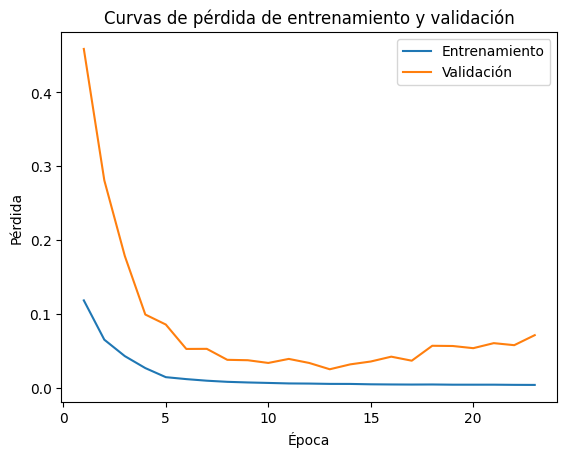

In [33]:
import matplotlib.pyplot as plt

# Obtén las curvas de pérdida de entrenamiento y validación del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crea el gráfico
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Entrenamiento')
plt.plot(epochs, val_loss, label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curvas de pérdida de entrenamiento y validación')
plt.legend()
plt.show()


# Modelo 2: GRU:

En este caso, el modelo está basado en una arquitectura de red recurrente utilizando capas GRU (Gated Recurrent Unit), una variante de la LSTM que tiene la misma capacidad para capturar dependencias de largo plazo pero con menos parámetros, lo que la hace más eficiente computacionalmente.

El modelo se construye con tres capas GRU, cada una seguida de una capa de regularización Dropout para evitar el sobreajuste. La primera capa GRU tiene 64 unidades, la segunda 32 y la tercera 16. Todas ellas utilizan la función de activación relu.

Para la entrada, estamos pasando bloques de tiempo de longitud 5, lo que significa que el modelo utiliza los últimos cinco pasos de tiempo disponibles para realizar predicciones, igual que en el modelo LSTM. Esto nos permite capturar patrones y relaciones relevantes en un horizonte temporal cercano, que pueden ser más informativos para la predicción a corto plazo.

La capa de salida es una capa densa con 3 unidades, que se correspondería con la predicción de los valores futuros de tres acciones diferentes.

Para la compilación de la red, utilizamos el optimizador SGD (Stochastic Gradient Descent) con una tasa de aprendizaje de 0.01 y una pérdida de Mean Squared Error, que es una elección común para tareas de regresión.

Además, se utiliza una estrategia de parada temprana durante el entrenamiento para detener el proceso de aprendizaje si el error de validación no mejora después de 10 épocas.

Finalmente, el modelo se entrena utilizando datos de entrenamiento y validación, midiendo su capacidad de generalización en diferentes períodos de tiempo.

Esperamos que este modelo de red recurrente para la predicción de series de tiempo de acciones sea una herramienta útil para aquellos interesados en aprovechar el poder de las redes neuronales en el análisis y la predicción de datos financieros.

In [34]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=64, return_sequences=True, input_shape=(5, 3), activation='relu'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=32, return_sequences=True, input_shape=(5, 3), activation='relu'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=16, return_sequences=True, input_shape=(5, 3), activation='relu'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=3))

# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mse')

early_stop = EarlyStopping(patience=10, monitor='val_loss', mode='min')

# Training the model with training and validation data
history = regressorGRU.fit(
    train_input[:, -5:, :],
    train_target[:, -1:, :],
    validation_data=(val_input[:, -5:, :], val_target[:, -1:, :]),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


23/23 [==============================] - 4s 27ms/step - loss: 0.0884 - val_loss: 0.2854
Epoch 2/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0519 - val_loss: 0.2916
Epoch 3/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0490 - val_loss: 0.2871
Epoch 4/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0477 - val_loss: 0.2892
Epoch 5/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0465 - val_loss: 0.2751
Epoch 6/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0463 - val_loss: 0.2720
Epoch 7/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0460 - val_loss: 0.2677
Epoch 8/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0446 - val_loss: 0.2555
Epoch 9/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0434 - val_loss: 0.2464
Epoch 10/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0425 - val_loss: 0.2370
Epoch 11/10

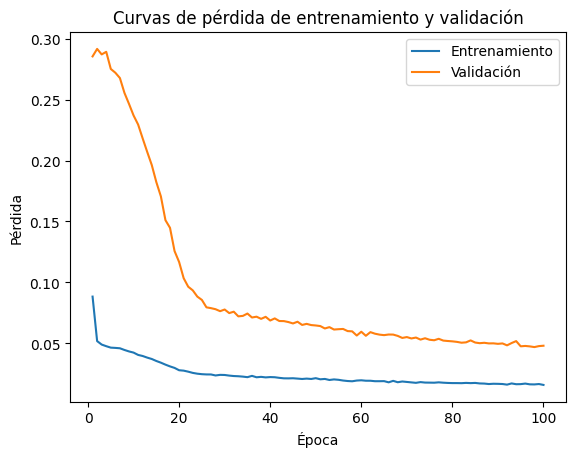

In [35]:
import matplotlib.pyplot as plt

# Obtén las curvas de pérdida de entrenamiento y validación del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crea el gráfico
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Entrenamiento')
plt.plot(epochs, val_loss, label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curvas de pérdida de entrenamiento y validación')
plt.legend()
plt.show()

# 3

In [36]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from transformers import BertModel, BertConfig

class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, num_heads):
        super(TransformerModel, self).__init__()

        assert input_size % num_heads == 0, "input_size must be divisible by num_heads"

        hidden_size = input_size // num_heads

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads),
            num_layers=6
        )

        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.mean(x, dim=1)
        x = self.fc(x)

        return x


In [41]:
# Define hyperparameters
input_size = 3  # Number of input features
output_size = 3  # Number of output features
num_heads = 3
lr = 0.001  # Learning rate
num_epochs = 10

# Convert the data to PyTorch tensors
train_input_tensor = torch.tensor(train_input, dtype=torch.float32)
train_target_tensor = torch.tensor(train_target, dtype=torch.float32)
val_input_tensor = torch.tensor(val_input, dtype=torch.float32)
val_target_tensor = torch.tensor(val_target, dtype=torch.float32)

# Move the tensors to the appropriate device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_input_tensor = train_input_tensor.to(device)
train_target_tensor = train_target_tensor.to(device)
val_input_tensor = val_input_tensor.to(device)
val_target_tensor = val_target_tensor.to(device)

# Create a DataLoader for the training set
train_dataset = data.TensorDataset(train_input_tensor, train_target_tensor)
train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the Transformer model
model = TransformerModel(input_size, output_size, num_heads)
model.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.MSELoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = loss_function(outputs[:, -prediction_days:, :], targets[:, -prediction_days:, :])
        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

    # Print the loss for monitoring
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluation
model.eval()
with torch.no_grad():
    # Perform evaluation on the validation set
    val_outputs = model(val_input_tensor)
    val_loss = loss_function(val_outputs, val_target_tensor)
    print(f"Validation Loss: {val_loss.item()}")

# Make predictions
test_input_tensor = torch.tensor(test_input, dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    test_outputs = model(test_input_tensor)


IndexError: ignored